In [32]:
import tensorflow as tf
import cv2
import numpy as np
mnist=tf.keras.datasets.mnist
(x_train,y_train),(x_test,y_test)=mnist.load_data()
(x_train,y_train),(x_test,y_test)=mnist.load_data()
x_trainr=np.array(x_train).reshape(-1,28,28,1)
x_testr=np.array(x_test).reshape(-1,28,28,1)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten,Conv2D,MaxPooling2D




model=Sequential()

model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=x_trainr.shape[1:])) 

model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=x_trainr.shape[1:])) 

model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=x_trainr.shape[1:])) 

model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation("relu"))
 
model.add(Dense(32))
model.add(Activation("relu"))

 
model.add(Dense(10))
model.add(Activation("softmax"))

model.compile(loss="sparse_categorical_crossentropy",optimizer="adam",metrics=['accuracy'])
model.fit(x_trainr,y_train ,epochs=5,validation_split=0.3)


Epoch 1/5
4200/4200 [==============================] - 59s 14ms/step - loss: 1.9948 - accuracy: 0.4973 - val_loss: 1.0824 - val_accuracy: 0.6308
Epoch 2/5
4200/4200 [==============================] - 62s 15ms/step - loss: 0.6385 - accuracy: 0.7999 - val_loss: 0.4125 - val_accuracy: 0.8813
Epoch 3/5
4200/4200 [==============================] - 61s 15ms/step - loss: 0.2674 - accuracy: 0.9334 - val_loss: 0.1701 - val_accuracy: 0.9574
Epoch 4/5
4200/4200 [==============================] - 64s 15ms/step - loss: 0.1556 - accuracy: 0.9595 - val_loss: 0.1803 - val_accuracy: 0.9551
Epoch 5/5
4200/4200 [==============================] - 64s 15ms/step - loss: 0.1314 - accuracy: 0.9675 - val_loss: 0.1577 - val_accuracy: 0.9583


In [77]:
img=cv2.imread("c.png")
gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
resized=cv2.resize(gray,(28,28),interpolation=cv2.INTER_AREA)
newimg=tf.keras.utils.normalize(resized,axis=1)
newimg3=np.array(newimg).reshape(-1,28,28,1)
predictions=model.predict(newimg3)

1/1 [==============================] - 0s 26ms/step


In [78]:
np.argmax(predictions)

7

In [51]:
pred=model.predict([x_testr])

313/313 [==============================] - 3s 9ms/step


In [7]:
import matplotlib.pyplot as plt

In [62]:
np.argmax(pred[ 889])

1

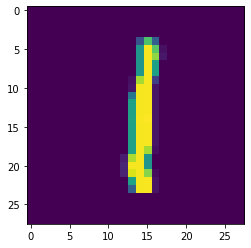

In [61]:
 plt.imshow(x_testr[889])

In [65]:
 

import numpy as np
# from scipy.misc.pilutil import imresize
from needed import imresize
from PIL import Image
import cv2  # version 3.2.0
from skimage.feature import hog
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle

DIGIT_WIDTH = 10
DIGIT_HEIGHT = 20
IMG_HEIGHT = 28
IMG_WIDTH = 28
CLASS_N = 10  # 0-9


# This method splits the input training image into small cells (of a single digit) and uses these cells as training data.
# The default training image (MNIST) is a 1000x1000 size image and each digit is of size 10x20. so we divide 1000/10 horizontally and 1000/20 vertically.
def split2d(img, cell_size, flatten=True):
    h, w = img.shape[:2]
    sx, sy = cell_size
    cells = [np.hsplit(row, w // sx) for row in np.vsplit(img, h // sy)]
    cells = np.array(cells)
    if flatten:
        cells = cells.reshape(-1, sy, sx)
    return cells


def load_digits(fn):
    print('loading "%s for training" ...' % fn)
    digits_img = cv2.imread(fn, 0)
    digits = split2d(digits_img, (DIGIT_WIDTH, DIGIT_HEIGHT))
    resized_digits = []
    for digit in digits:
        resized_digits.append(imresize(digit, (IMG_WIDTH, IMG_HEIGHT)))
    labels = np.repeat(np.arange(CLASS_N), len(digits) / CLASS_N)
    return np.array(resized_digits), labels


def pixels_to_hog_20(img_array):
    hog_featuresData = []
    for img in img_array:
        fd = hog(img,
                 orientations=10,
                 pixels_per_cell=(5, 5),
                 cells_per_block=(1, 1))
        hog_featuresData.append(fd)
    hog_features = np.array(hog_featuresData, 'float64')
    return np.float32(hog_features)


# define a custom model in a similar class wrapper with train and predict methods
class KNN_MODEL():
    def __init__(self, k=3):
        self.k = k
        self.model = cv2.ml.KNearest_create()

    def train(self, samples, responses):
        self.model.train(samples, cv2.ml.ROW_SAMPLE, responses)

    def predict(self, samples):
        retval, results, neigh_resp, dists = self.model.findNearest(samples, self.k)
        return results.ravel()


class SVM_MODEL():
    def __init__(self, num_feats, C=1, gamma=0.1):
        self.model = cv2.ml.SVM_create()
        self.model.setType(cv2.ml.SVM_C_SVC)
        self.model.setKernel(cv2.ml.SVM_RBF)  # SVM_LINEAR, SVM_RBF
        self.model.setC(C)
        self.model.setGamma(gamma)
        self.features = num_feats

    def train(self, samples, responses):
        self.model.train(samples, cv2.ml.ROW_SAMPLE, responses)

    def predict(self, samples):
        results = self.model.predict(samples.reshape(-1, self.features))
        return results[1].ravel()


def get_digits(contours, hierarchy):
    hierarchy = hierarchy[0]
    bounding_rectangles = [cv2.boundingRect(ctr) for ctr in contours]
    final_bounding_rectangles = []
    # find the most common heirarchy level - that is where our digits's bounding boxes are
    u, indices = np.unique(hierarchy[:, -1], return_inverse=True)
    most_common_heirarchy = u[np.argmax(np.bincount(indices))]

    for r, hr in zip(bounding_rectangles, hierarchy):
        x, y, w, h = r
        # this could vary depending on the image you are trying to predict
        # we are trying to extract ONLY the rectangles with images in it (this is a very simple way to do it)
        # we use heirarchy to extract only the boxes that are in the same global level - to avoid digits inside other digits
        # ex: there could be a bounding box inside every 6,9,8 because of the loops in the number's appearence - we don't want that.
        # read more about it here: https://docs.opencv.org/trunk/d9/d8b/tutorial_py_contours_hierarchy.html
        if ((w * h) > 250) and (10 <= w <= 200) and (10 <= h <= 200) and hr[3] == most_common_heirarchy:
            final_bounding_rectangles.append(r)

    return final_bounding_rectangles


def proc_user_img(img_file, model):
    print('loading "%s for digit recognition" ...' % img_file)
    im = cv2.imread(img_file)
    blank_image = np.zeros((im.shape[0], im.shape[1], 3), np.uint8)
    blank_image.fill(255)

    imgray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    plt.imshow(imgray)
    kernel = np.ones((5, 5), np.uint8)

    ret, thresh = cv2.threshold(imgray, 127, 255, 0)
    thresh = cv2.erode(thresh, kernel, iterations=1)
    thresh = cv2.dilate(thresh, kernel, iterations=1)
    thresh = cv2.erode(thresh, kernel, iterations=1)

    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    digits_rectangles = get_digits(contours, hierarchy)  # rectangles of bounding the digits in user image

    for rect in digits_rectangles:
        x, y, w, h = rect
        cv2.rectangle(im, (x, y), (x + w, y + h), (0, 255, 0), 2)
        im_digit = imgray[y:y + h, x:x + w]
        im_digit = (255 - im_digit)
        im_digit = imresize(im_digit, (IMG_WIDTH, IMG_HEIGHT))

        hog_img_data = pixels_to_hog_20([im_digit])
        pred = model.predict(hog_img_data)
        cv2.putText(im, str(int(pred[0])), (x, y), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 0, 0), 3)
        cv2.putText(blank_image, str(int(pred[0])), (x, y), cv2.FONT_HERSHEY_SIMPLEX, 3, (255, 0, 0), 5)

    plt.imshow(im)
    cv2.imwrite("original_overlay.png", im)
    cv2.imwrite("final_digits.png", blank_image)
    # cv2.destroyAllWindows()


def get_contour_precedence(contour, cols):
    return contour[1] * cols + contour[0]  # row-wise ordering


# this function processes a custom training image
# see example : custom_train.digits.jpg
# if you want to use your own, it should be in a similar format
def load_digits_custom(img_file):
    train_data = []
    train_target = []
    start_class = 1
    im = cv2.imread(img_file)
    imgray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    plt.imshow(imgray)
    kernel = np.ones((5, 5), np.uint8)

    ret, thresh = cv2.threshold(imgray, 127, 255, 0)
    thresh = cv2.erode(thresh, kernel, iterations=1)
    thresh = cv2.dilate(thresh, kernel, iterations=1)
    thresh = cv2.erode(thresh, kernel, iterations=1)

    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    digits_rectangles = get_digits(contours, hierarchy)  # rectangles of bounding the digits in user image

    # sort rectangles accoring to x,y pos so that we can label them
    digits_rectangles.sort(key=lambda x: get_contour_precedence(x, im.shape[1]))

    for index, rect in enumerate(digits_rectangles):
        x, y, w, h = rect
        cv2.rectangle(im, (x, y), (x + w, y + h), (0, 255, 0), 2)
        im_digit = imgray[y:y + h, x:x + w]
        im_digit = (255 - im_digit)

        im_digit = imresize(im_digit, (IMG_WIDTH, IMG_HEIGHT))
        train_data.append(im_digit)
        train_target.append(start_class % 10)

        if index > 0 and (index + 1) % 10 == 0:
            start_class += 1
    cv2.imwrite("training_box_overlay.png", im)

    return np.array(train_data), np.array(train_target)


# ------------------data preparation--------------------------------------------

TRAIN_MNIST_IMG = 'digits.png'
TRAIN_USER_IMG = 'custom_train_digits.jpg'
TEST_USER_IMG = 'test_image.png'

# digits, labels = load_digits(TRAIN_MNIST_IMG) #original MNIST data (not good detection)
digits, labels = load_digits_custom(
    TRAIN_USER_IMG)  # my handwritten dataset (better than MNIST on my handwritten digits)

print('train data shape', digits.shape)
print('test data shape', labels.shape)

digits, labels = shuffle(digits, labels, random_state=256)
train_digits_data = pixels_to_hog_20(digits)
X_train, X_test, y_train, y_test = train_test_split(train_digits_data, labels, test_size=0.33, random_state=42)

# ------------------training and testing----------------------------------------

model = KNN_MODEL(k=3)
model.train(X_train, y_train)
preds = model.predict(X_test)
print('Accuracy: ', accuracy_score(y_test, preds))

model = KNN_MODEL(k=4)
model.train(train_digits_data, labels)
proc_user_img(TEST_USER_IMG, model)

model = SVM_MODEL(num_feats=train_digits_data.shape[1])
model.train(X_train, y_train)
preds = model.predict(X_test)
print('Accuracy: ', accuracy_score(y_test, preds))

model = SVM_MODEL(num_feats=train_digits_data.shape[1])
model.train(train_digits_data, labels)
proc_user_img(TEST_USER_IMG, model)

ModuleNotFoundError: No module named 'needed'

In [66]:
!pip install needed

ERROR: Could not find a version that satisfies the requirement needed (from versions: none)
ERROR: No matching distribution found for needed


In [68]:
import tensorflow as tf
 
from tensorflow import keras

# load the data
(train_img,train_label),(test_img,test_label) = keras.datasets.mnist.load_data()
train_img = train_img.reshape([-1, 28, 28, 1])
test_img = test_img.reshape([-1, 28, 28, 1])
train_img = train_img/255.0
test_img = test_img/255.0
train_label = keras.utils.to_categorical(train_label)
test_label = keras.utils.to_categorical(test_label)

# define the model architecture
model = keras.Sequential([
    keras.layers.Conv2D(32, (5, 5), padding="same", input_shape=[28, 28, 1]),
    keras.layers.MaxPool2D((2,2)),
    keras.layers.Conv2D(64, (5, 5), padding="same"),
    keras.layers.MaxPool2D((2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(1024, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(10, activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# train the model
model.fit(train_img,train_label, validation_data=(test_img,test_label), epochs=10)
test_loss,test_acc = model.evaluate(test_img, test_label)
print('Test accuracy:', test_acc)

# save model as tfjs format
 

Epoch 1/10
1875/1875 [==============================] - 80s 42ms/step - loss: 0.1185 - accuracy: 0.9650 - val_loss: 0.0568 - val_accuracy: 0.9825
Epoch 2/10
1875/1875 [==============================] - 81s 43ms/step - loss: 0.0552 - accuracy: 0.9835 - val_loss: 0.0383 - val_accuracy: 0.9879
Epoch 3/10
1875/1875 [==============================] - 85s 45ms/step - loss: 0.0438 - accuracy: 0.9870 - val_loss: 0.0602 - val_accuracy: 0.9844
Epoch 4/10
1875/1875 [==============================] - 87s 47ms/step - loss: 0.0395 - accuracy: 0.9892 - val_loss: 0.0775 - val_accuracy: 0.9798
Epoch 5/10
1875/1875 [==============================] - 91s 49ms/step - loss: 0.0351 - accuracy: 0.9909 - val_loss: 0.0607 - val_accuracy: 0.9895
Epoch 6/10
1875/1875 [==============================] - 94s 50ms/step - loss: 0.0339 - accuracy: 0.9915 - val_loss: 0.0835 - val_accuracy: 0.9838
Epoch 7/10
1875/1875 [==============================] - 96s 51ms/step - loss: 0.0335 - accuracy: 0.9925 - val_loss: 0.0803 -

NameError: name 'tfjs' is not defined